# Simulated time series

In this example, we generate discrete time series data from a model with known parameters $W$. The `FEM` package provides functions for generating models and data. After generating the data, we demonstrate how to use `FEM` to infer the model. In this simulated data scenario, we can compare our inferred model to the known true model.

We start by importing the necessary packages and ensuring that Pyplot places its output in the notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fem

Next, we generate model parameters for discrete data using the `fem.discrete.model_parameters` helper function. As in the [FEM for discrete data](../../discrete.rst) section, $n$ denotes the number of variables, and $m$ denotes the number of states that each variable takes. In this case, we restrict each variable to taking the same number $m$ states as all the other variables by passing an integer `m` to the function, though the function supports `m` an iterable of length `n` that specifies the number of states per variable. We also specify the degrees of $W$ desired with the `degs` list.

In [2]:
n, m, degs = 10, 3, [1]
w = fem.discrete.simulate.model_parameters(n, m, degs)

The model parameters `w` are returned as a dictionary with `degs` as keys. By default the parameters in `w` are sampled from a normal distribution with mean 0 and variance $1/\sqrt{mn}$ (using optional arguments `dist=np.random.normal` and `dist_par=(0, 1/np.sqrt(m*n))`). We plot `w` as an image and flatten out `w` to a 1D array and plot the distribution:

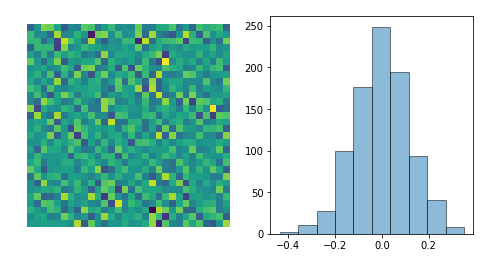

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].matshow(w[1])
ax[0].axis('off')
w_flat = np.hstack([wi for wi in w.itervalues()]).flatten()
hist = ax[1].hist(w_flat, bins=n, ec='k', alpha=0.5)

Now that we have a model represented by `w`, we generate time series data using the `fem.discrete.simulate.time_series` function. We specify with the parameter `o` that the number of time points to be returned is $o$ times the number of model parameters ($(mn)^2$ in this case). We could instead specify a number of time points with the optional argument `l`. For time series data, the probability that a variable $x_i$ is in state $j$ at time $t+1$ depends on the one hot encoding $\sigma(t)$ of all the $x_i$ at $t$:

$$p(x_{i}(t+1)=j~|~\sigma(t)) = {\exp{(h_{(i-1)m + j})} \over \sum_{k=1}^m\exp{(h_{(i-1)m + k}})}$$

where $h = W \sigma(t).$

In [4]:
x = fem.discrete.simulate.time_series(w, n, m, o=5.0)

Let's examine the generated data. Each variable takes `m=3` unique states as expected. By default, these are symbolized by the first nonnegative integers. The average of each variable is approximately 1.

In [5]:
tab = []
for i in range(n):
    tab.append([np.unique(x[i]), x[i].mean()])
pd.DataFrame(data=tab, columns=['states', 'average'], index=1+np.arange(n))

,states,average
1,"[0, 1, 2]",1.026222
2,"[0, 1, 2]",1.005111
3,"[0, 1, 2]",0.992667
4,"[0, 1, 2]",1.025111
5,"[0, 1, 2]",0.988444
6,"[0, 1, 2]",1.017778
7,"[0, 1, 2]",0.967556
8,"[0, 1, 2]",0.990000
9,"[0, 1, 2]",0.989333
10,"[0, 1, 2]",0.985111


Plotting the first 100 time points of each variable, there is no discernable pattern to the naked eye:

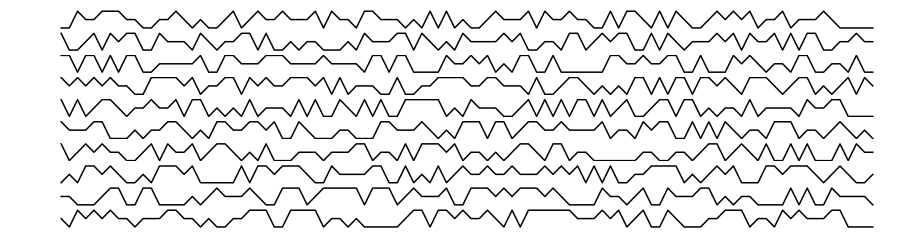

In [6]:
fig, ax = plt.subplots(n, 1, figsize=(16,4))
for i in range(n):
    ax[i].plot(x[i, :100], 'k-')
    ax[i].axis('off')

We can however determine the model that generated the above data using FEM. We start by splitting the data into two sets `x1`, which contains all but the last time point, and `x2`, which contains all but the first time point. Next, we use the `fem.discrete.fit.fit` function to infer the `w` that is used to map `x1` to `x2`. In this case, we require a fixed number of iterations of the method with the `iters` argument.

In [7]:
x1, x2 = x[:, :-1], x[:, 1:]
w_fit, disc = fem.discrete.fit.fit(x1, x2, degs, iters=50)

The fit function returns the inferred parameters (`w_fit` above) as a dictionary with keys `degs` and it returns the running discrepancy for each variable in the model (`disc` above). Below we make a scatter plot of the inferred `w_fit` model parameters versus the true `w` model parameters. Since, the points are scattered around the line $y=x$, we confirm that the algorithm accurately recovers the true model parameters.

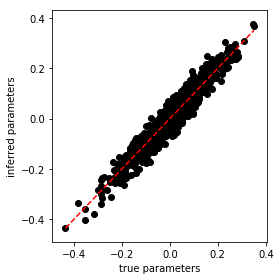

In [8]:
w_fit_flat = np.hstack([wi for wi in w_fit.itervalues()]).flatten()

fig = plt.figure(figsize=(4,4))
ax = plt.gca()

ax.scatter(w_flat, w_fit_flat, c='k')
lo, hi = w_flat.min(), w_flat.max()
grid = np.linspace(lo, hi)
ax.plot(grid, grid, 'r--')
ax.set_xlabel('true parameters')
ax.set_ylabel('inferred parameters')
    
plt.tight_layout()
plt.show()